# Open exploration - uncertainties

- Perform experiments for ten sampled policies *plus zero policy* and per policy 1,000 sampled scnenarios (both sampling using lhs).
- Evaluate the influence of different uncertainties have on the outcomes: (1) expected damage, (2) expected number of deaths, and (3) total costs.

In [27]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from model.problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

In [3]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_10000runs_2steps.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs_2steps.tar.gz


Wall time: 1h 2min 32s


In [3]:
results = load_results('./results/open_exploration_uncertainties_10000runs_2steps.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs_2steps.tar.gz


In [4]:
# use the same 1,000 sampled scenarios, run for zero policy
sampled_scenarios = experiments.loc[:, [u.name for u in dike_model.uncertainties]]
sampled_scenarios.drop_duplicates(inplace=True)
ref_scenarios = [Scenario(i, **scenario.to_dict())
                 for i, scenario in pd.DataFrame.from_dict(sampled_scenarios).iterrows()] # sampled scenarios

# make a policy instance for zero policy
policy0 = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}
ref_policy = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    ref_policy.update({key.name: policy0[s]})
ref_policy0 = Policy('baseline', **ref_policy) # policy0

In [6]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenarios, 
                                            policies=ref_policy0) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_policy0_2steps.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps.tar.gz


Wall time: 7min 11s


In [5]:
results_policy0 = load_results('./results/open_exploration_uncertainties_policy0_2steps.tar.gz')

experiments_policy0, outcomes_policy0 = results_policy0

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps.tar.gz


In [6]:
## concat the results of policy0 with previous experiments and outcomes

# first make copies from sampled results
experiments_w0 = experiments.copy() 
outcomes_w0 = outcomes.copy()

# then merge with results of zero policy 
experiments_w0 = pd.concat([experiments_policy0, experiments_w0], axis=0, sort=False)
experiments_w0.reset_index(drop=True, inplace=True)
for key in outcomes:
    outcomes_w0.update({key: np.append(outcomes_policy0[key], outcomes_w0[key])})

## The outcomes

We first inspect the outcomes by boxplots. From the graphs we can see that the results for *Total Investment Costs* is quite normally distributed (with outliers being the zero policy cases), while those for *Expected Annual Damage* and *Expected Number of Deaths* contain many extreme "outliers". These findings are aligned with the following parewise scatterplot.

Note that *Total Investment Costs* is only related to the levers.

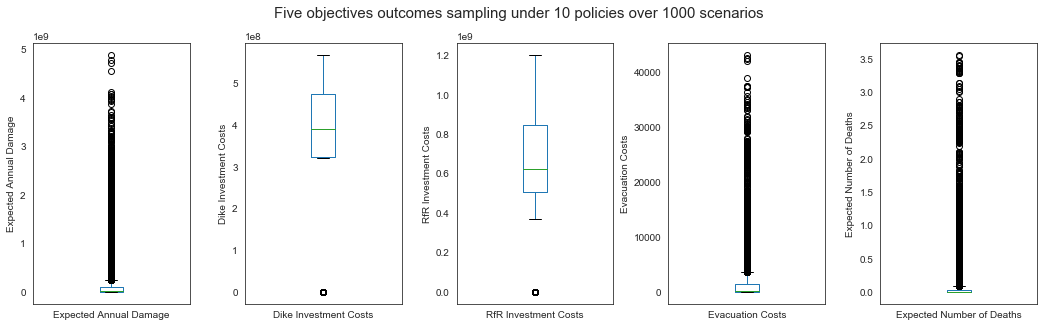

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
plt.subplots_adjust(wspace=0.35, top=0.85)
kpis = pd.DataFrame([key.name for key in dike_model.outcomes])
fig.suptitle('Five objectives outcomes sampling under 10 policies over 1000 scenarios', y=0.95, fontsize=15)

for i, key in kpis.iterrows():
    pd.Series(outcomes_w0[key[0]]).plot(kind='box', ax=axes[i], label=key[0])
    axes[i].set_ylabel(key[0])

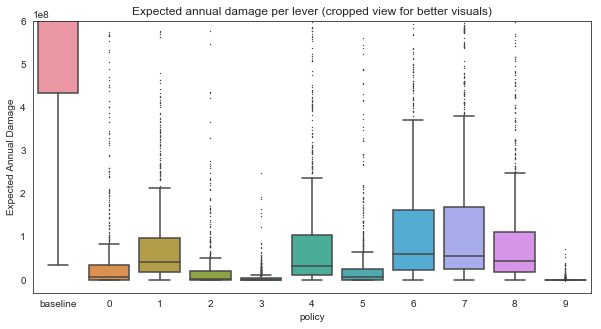

In [15]:
# check distribution of expected annual damage per lever
damage = pd.DataFrame({'policy' : experiments_w0.policy,
                       'Expected Annual Damage' : outcomes_w0['Expected Annual Damage']})

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=damage, x='policy', y='Expected Annual Damage', fliersize=0.5)
ax.set_title('Expected annual damage per lever (cropped view for better visuals)')
ax.set_ybound(-3e7, 6e8) # zoom-in for better visuals

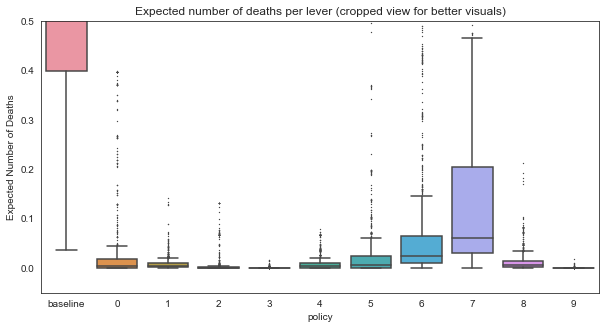

In [20]:
# check distribution of expected number of deaths per lever
deaths = pd.DataFrame({'policy' : experiments_w0.policy,
                       'Expected Number of Deaths' : outcomes_w0['Expected Number of Deaths']})

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=deaths, x='policy', y='Expected Number of Deaths', fliersize=0.5)
ax.set_title('Expected number of deaths per lever (cropped view for better visuals)')
ax.set_ybound(-0.05, 0.5) # zoom-in for better visuals

## Pairwise scatterplot

From the graphs we can see that **"no action" (zero policy) is NOT a good action**: a random lever can significantly reduce the *Expected Number of Deaths* and *Expected Annual Damage*, although the costs resulted from the introduced lever could be around the same order of the damage.

We can also see that the outcomes of *Expected Number of Deaths* and *Expected Annual Damage* are highly correlated, and different policies result in different "damage-to-deaths" ratios across scenarios.

### *Pairwise plot showing sampled policies and also zero policy*

[MainProcess/INFO] no time dimension found in results


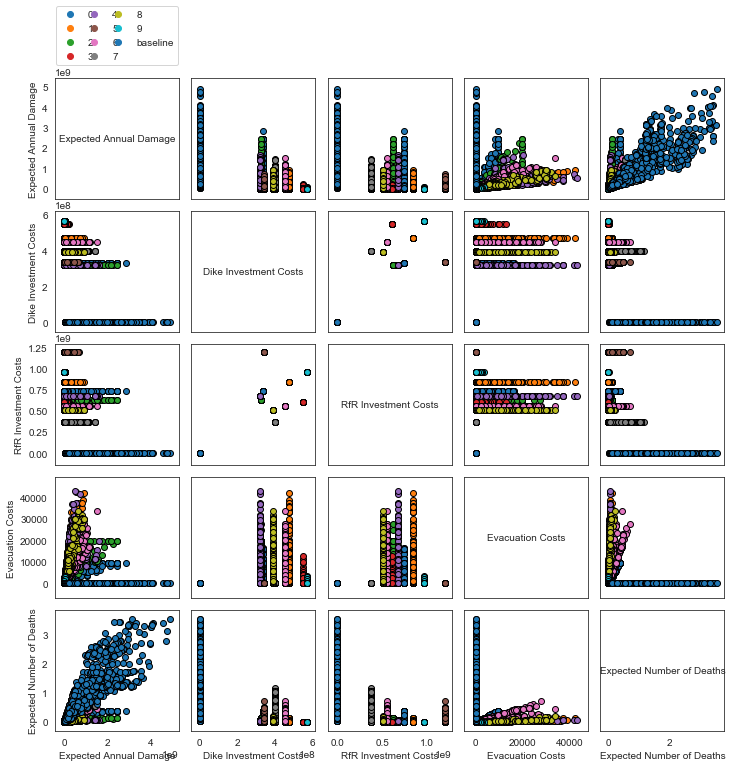

In [15]:
fig, ax = pairs_plotting.pairs_scatter(experiments_w0, outcomes_w0, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

### *Pairwise plot showing only sampled policies*

[MainProcess/INFO] no time dimension found in results


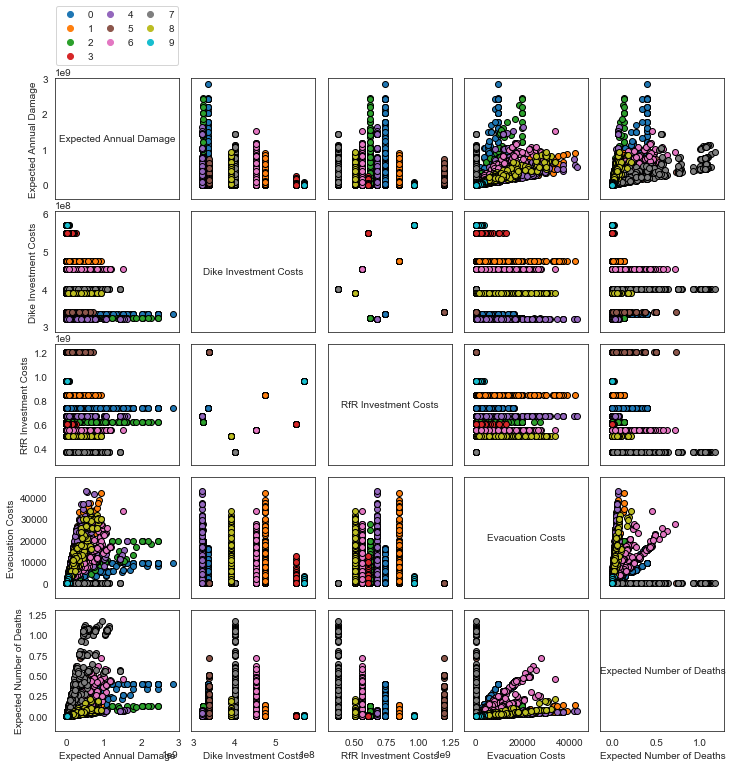

In [16]:
fig, ax = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

## Feature scoring

We then perform feature scoring for all outcomes to find out on which outcome does which uncertainty has the largest influence. We drop the investment and evacuation costs here as they are irrelevant to uncertainties.

From the results, we see that both *Expected Annual Damage* and *Expected Number of Deaths* are primarily influenced by **dike failure probability at Doesburg (A.1) and Zutphen (A.3)**, while the growth rates of breach width (Brate) seem to have limited influence on expected damage.

In [31]:
# remove investment and evacuation costs as they are irrelevant to uncertainties
costs = ['Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']
for var in costs:
    del outcomes_w0[var]

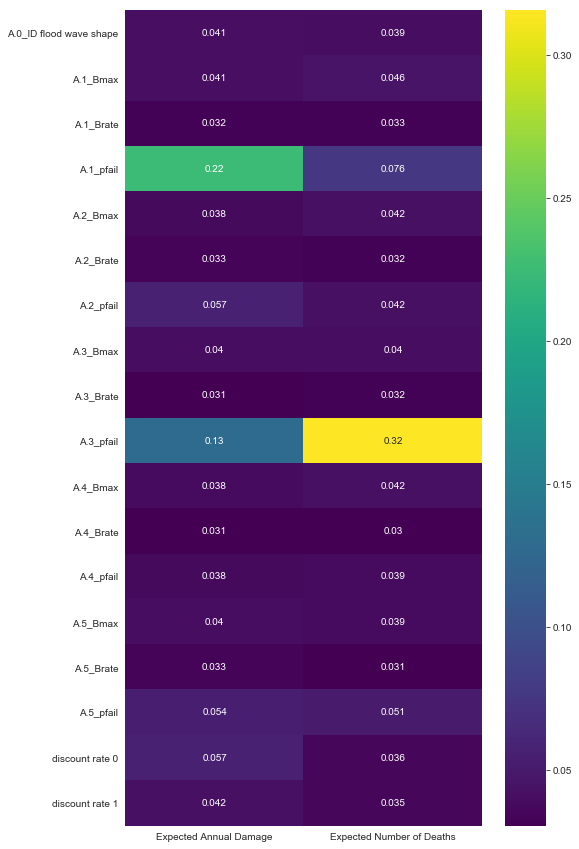

In [32]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes_w0

fs = feature_scoring.get_feature_scores_all(x, y, mode=RuleInductionType.REGRESSION)
plt.figure(figsize = (8,15))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

## Dimensional stacking & PRIM

We can further apply dimensional stacking to create a heatmap showing the influences of the most important uncertainties, and PRIM to identify the range of those uncertainties. We can plot it for both expected damage and number of deaths. 

### 1. Expected Annual Damage < 1 billion EUR

We set 1 billion EUR as the threshold for subspace partitioning of damage as we saw previously the costs of the levers are in general at this scale. The dimensional stacking plot and PRIM show that the most infuential uncertainties for expected damage are again the dike failure probabilities. The results suggest that in scenarios where **pfail at Doesburg (A.1) > 0.47** and **pfail at Zutphen (A.3) > 0.3**, the annual damage is expected to be below the one-billion EUR threshold.

In [66]:
# threshold for subspace partitioning for damage
THRESHOLD_DAMAGE = 1e9

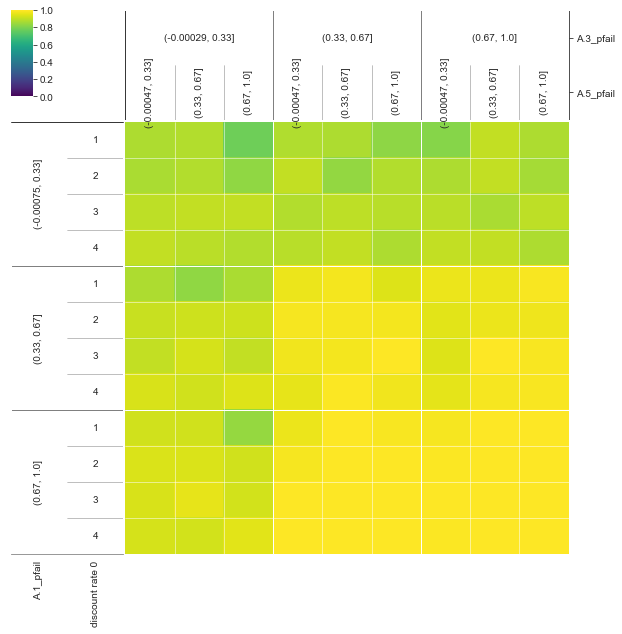

In [71]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes_w0['Expected Annual Damage'] < THRESHOLD_DAMAGE

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [72]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 11000 points remaining, containing 10307 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.302, coverage: 0.3223052294557097, density: 1.0 restricted_dimensions: 4


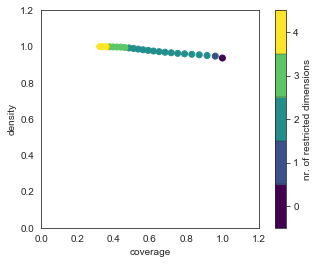

In [73]:
box1.show_tradeoff()
plt.show()

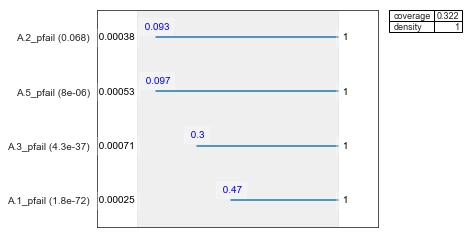

In [65]:
box1.inspect(style='graph')
plt.show()

### 2. Expected Number of Deaths < 0.5 person

We set 0.5 person as the threshold for subspace partitioning of number of deaths. The dimensional stacking plot and PRIM show that the most infuential uncertainties for expected number of deaths are the dike failure probabilities. Scenarios where much higher pfail's at Doesburg (A.1) Zutphen (A.3) occur tend to result in less deaths.

In [74]:
# threshold for subspace partitioning for deaths
THRESHOLD_DEATHS = 0.5

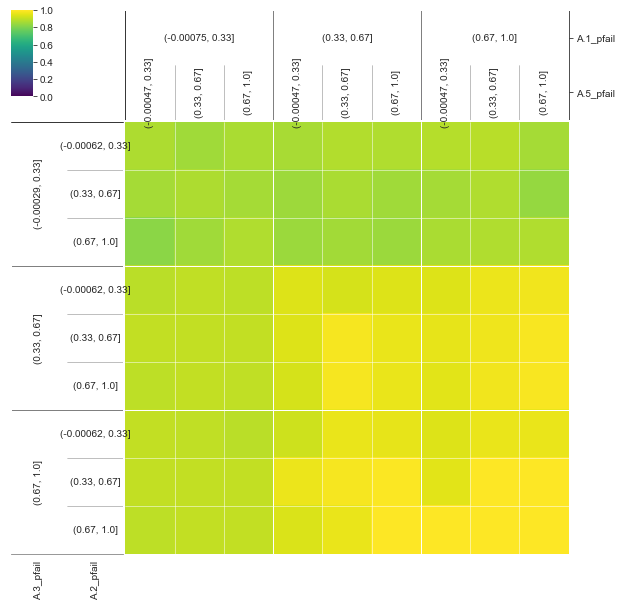

In [75]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes_w0['Expected Number of Deaths'] < THRESHOLD_DEATHS

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [76]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box2 = prim_alg.find_box()

[MainProcess/INFO] 11000 points remaining, containing 10130 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.219, coverage: 0.23780848963474827, density: 1.0 restricted_dimensions: 4


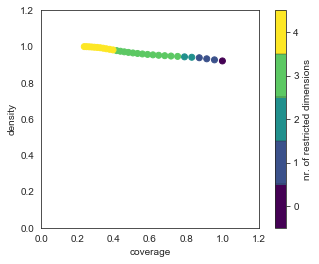

In [77]:
box2.show_tradeoff()
plt.show()

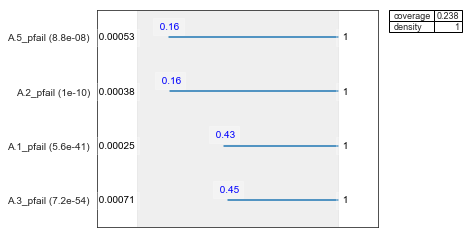

In [78]:
box2.inspect(style='graph')
plt.show()

## Appendix

#### *The ten sampled levers*

In [21]:
levers = experiments.loc[:, [l.name for l in dike_model.levers]]
levers = levers.drop_duplicates()
levers.index = experiments.policy.unique() # align with policy no.
levers.T # transpose for seeing all levers

,0,1,2,3,4,5,6,7,8,9
0_RfR 0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
0_RfR 1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1_RfR 0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1_RfR 1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2_RfR 0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2_RfR 1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3_RfR 0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3_RfR 1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4_RfR 0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4_RfR 1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
